In [1]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from utils import params_to_dataframe

Train accuracy:  1.0
Test accuracy:  1.0


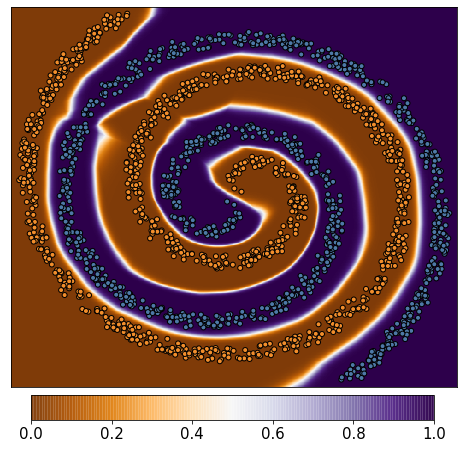

In [21]:
h = 0.05
def plot_boundary(clf, X, y, X_test=None, y_test=None):
    fig, ax = plt.subplots(figsize=(8, 7))

    cm = plt.cm.PuOr
    #cm = ListedColormap(['#F28E2C', '#4E79A7'])
    #cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    cm_bright = ListedColormap(['#F28E2C', '#4E79A7'])
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #imshow_handle = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8, vmin=0, vmax=1)
    imshow_handle = plt.pcolormesh(xx, yy, Z, cmap=cm, alpha=.8, vmin=0, vmax=1)
    imshow_handle.set_clim(0.0, 1.0)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
               edgecolors='black', s=25)
    # and testing points
    #plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
    #           alpha=0.6, edgecolors='black', s=25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax = plt.axes([0.16, 0.06, 0.7, 0.05])
    #plt.title("Probability")
    cbar = plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=15) 
    
plot_boundary(model, trnX, trny, tstX, tsty)
print("Train accuracy: ", (model.predict(trnX) == trny).mean())
print("Test accuracy: ", (model.predict(tstX) == tsty).mean())

plt.savefig("../figs/sprial.9_trades.png", transparent=True)

In [2]:
def twospirals(n_points, noise=.5, random_seed=0):
    """
     Returns the two spirals dataset.
    """
    random_state = np.random.RandomState(random_seed)
    n = np.sqrt(random_state.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + random_state.rand(n_points,1) * noise
    d1y = np.sin(n)*n + random_state.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

trnX, trny = twospirals(1000, 0.9)
tstX, tsty = twospirals(1000, 0.9)

dist = pairwise_distances(trnX, metric='chebyshev')
for i in range(len(trnX)):
    for j in range(len(trnX)):
        if trny[i] == trny[j]:
            dist[i][j] = np.inf
dist.min()

0.7052012353399588

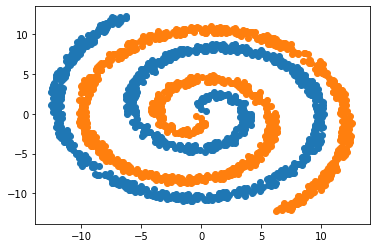

In [23]:
plt.scatter(trnX[trny==0, 0], trnX[trny==0, 1])
plt.scatter(trnX[trny==1, 0], trnX[trny==1, 1])

In [22]:
attack = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps/5,
    nb_iter=10,
    preprocess_img=False,
    device='cpu',
)
print("adv trn acc: ", (model.predict(attack.perturb(trnX, trny)) == trny).mean())
print("adv tst acc: ", (model.predict(attack.perturb(tstX, tsty)) == tsty).mean())

adv trn acc:  0.99
adv tst acc:  0.99


In [10]:
ttt = attack.perturb(tstX, tsty)

In [9]:
ttt.max()

NameError: name 'ttt' is not defined

In [20]:
eps = 0.35
batch_size = 128
auto_var.set_variable_value("random_seed", 0)
#trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "halfmoon-800-0.25")
#model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="ce", architecture="LargeMLP", epochs=70, learning_rate=1e-2, device="cpu", batch_size=batch_size, optimizer="adam")
#model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="advce", architecture="LargeMLP", epochs=160, learning_rate=1e-2, device="cpu", batch_size=batch_size, optimizer="adam", eps=eps, norm=np.inf)
model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="stradesce", architecture="LargeMLP", epochs=70, learning_rate=1e-2, device="cpu", batch_size=batch_size, optimizer="adam", eps=eps, norm=np.inf)

_ = model.fit(trnX, trny, verbose=0)
print((model.predict(trnX) == trny).mean())

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

lr: 0.01, opt: adam, loss: stradesce, arch: LargeMLP, dataaug: None, batch_size: 128, momentum: 0.0, weight_decay: 0.0


Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 1/70, train loss: 1.182, train acc: 0.522


Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 2/70, train loss: 0.672, train acc: 0.555


Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 3/70, train loss: 0.672, train acc: 0.571


Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 4/70, train loss: 0.668, train acc: 0.582


Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 5/70, train loss: 0.673, train acc: 0.559


Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 6/70, train loss: 0.670, train acc: 0.578


Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 7/70, train loss: 0.670, train acc: 0.581


Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 8/70, train loss: 0.664, train acc: 0.567


Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 9/70, train loss: 0.663, train acc: 0.584


Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 10/70, train loss: 0.660, train acc: 0.604


Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 11/70, train loss: 0.663, train acc: 0.609


Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 12/70, train loss: 0.654, train acc: 0.603


Epoch 14:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 13/70, train loss: 0.656, train acc: 0.610


Epoch 15:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 14/70, train loss: 0.650, train acc: 0.600


Epoch 16:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 15/70, train loss: 0.634, train acc: 0.622


Epoch 17:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 16/70, train loss: 0.629, train acc: 0.645


Epoch 18:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 17/70, train loss: 0.645, train acc: 0.611


Epoch 19:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 18/70, train loss: 0.637, train acc: 0.626


Epoch 20:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 19/70, train loss: 0.611, train acc: 0.642


Epoch 21:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 20/70, train loss: 0.579, train acc: 0.646


Epoch 22:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 21/70, train loss: 0.504, train acc: 0.688


Epoch 23:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 22/70, train loss: 0.500, train acc: 0.742


Epoch 24:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 23/70, train loss: 0.437, train acc: 0.795


Epoch 25:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 24/70, train loss: 0.276, train acc: 0.886


Epoch 26:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 25/70, train loss: 0.281, train acc: 0.888


Epoch 27:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 26/70, train loss: 0.219, train acc: 0.927


Epoch 28:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 27/70, train loss: 0.159, train acc: 0.962


Epoch 29:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 28/70, train loss: 0.112, train acc: 0.992


Epoch 30:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 29/70, train loss: 0.073, train acc: 0.999


Epoch 31:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 30/70, train loss: 0.069, train acc: 0.998


Epoch 32:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 31/70, train loss: 0.080, train acc: 0.992


Epoch 33:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 32/70, train loss: 0.096, train acc: 0.989


Epoch 34:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 33/70, train loss: 0.065, train acc: 0.998


Epoch 35:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 34/70, train loss: 0.065, train acc: 0.999


Epoch 36:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 35/70, train loss: 0.131, train acc: 0.982


Epoch 37:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 36/70, train loss: 0.073, train acc: 0.996


Epoch 38:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 37/70, train loss: 0.058, train acc: 0.998


Epoch 39:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 38/70, train loss: 0.088, train acc: 0.997


Epoch 40:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 39/70, train loss: 0.079, train acc: 0.998


Epoch 41:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.01
epoch: 40/70, train loss: 0.077, train acc: 0.994


Epoch 42:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 41/70, train loss: 0.040, train acc: 1.000


Epoch 43:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 42/70, train loss: 0.026, train acc: 1.000


Epoch 44:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 43/70, train loss: 0.024, train acc: 1.000


Epoch 45:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 44/70, train loss: 0.022, train acc: 1.000


Epoch 46:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 45/70, train loss: 0.025, train acc: 1.000


Epoch 47:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 46/70, train loss: 0.022, train acc: 1.000


Epoch 48:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 47/70, train loss: 0.023, train acc: 1.000


Epoch 49:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 48/70, train loss: 0.022, train acc: 1.000


Epoch 50:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 49/70, train loss: 0.021, train acc: 1.000


Epoch 51:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 50/70, train loss: 0.021, train acc: 1.000


Epoch 52:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 51/70, train loss: 0.020, train acc: 1.000


Epoch 53:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 52/70, train loss: 0.021, train acc: 1.000


Epoch 54:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 53/70, train loss: 0.021, train acc: 1.000


Epoch 55:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 54/70, train loss: 0.022, train acc: 1.000


Epoch 56:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 55/70, train loss: 0.020, train acc: 1.000


Epoch 57:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 56/70, train loss: 0.020, train acc: 1.000


Epoch 58:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 57/70, train loss: 0.022, train acc: 1.000


Epoch 59:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 58/70, train loss: 0.020, train acc: 1.000


Epoch 60:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 59/70, train loss: 0.021, train acc: 1.000


Epoch 61:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.001
epoch: 60/70, train loss: 0.020, train acc: 1.000


Epoch 62:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 61/70, train loss: 0.022, train acc: 1.000


Epoch 63:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 62/70, train loss: 0.018, train acc: 1.000


Epoch 64:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 63/70, train loss: 0.018, train acc: 1.000


Epoch 65:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 64/70, train loss: 0.017, train acc: 1.000


Epoch 66:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 65/70, train loss: 0.021, train acc: 1.000


Epoch 67:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 66/70, train loss: 0.019, train acc: 1.000


Epoch 68:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 67/70, train loss: 0.018, train acc: 1.000


Epoch 69:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 68/70, train loss: 0.019, train acc: 1.000


Epoch 70:   0%|          | 0/16 [00:00<?, ?it/s]

current LR: 0.00010000000000000002
epoch: 69/70, train loss: 0.019, train acc: 1.000


Epoch 70: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]

current LR: 0.00010000000000000002
epoch: 70/70, train loss: 0.019, train acc: 1.000


1.0
